In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

In [2]:
# 🔹 Step 1: Load & Preprocess Data
ad_data = pd.read_csv("raw_sample.csv", usecols=["user", "adgroup_id", "nonclk"])
ecommerce_data = pd.read_csv("UserBehavior.csv")
ecommerce_data.columns = ['user_id', 'item_id', 'category_id', 'behavior_type', 'timestamp']



In [3]:
# Rename columns for consistency
ad_data.rename(columns={"user": "user_id", "adgroup_id": "item_id", "nonclk": "interaction"}, inplace=True)
ecommerce_data["interaction"] = ecommerce_data["behavior_type"].apply(lambda x: 1 if x == "buy" else 0)

# Keep only relevant columns
ad_data = ad_data[["user_id", "item_id", "interaction"]]
ecommerce_data = ecommerce_data[["user_id", "item_id", "interaction"]]


In [36]:
# 🔹 Step 2: Filter Common Users & Sample 20%
common_users = list(set(ad_data["user_id"]).intersection(set(ecommerce_data["user_id"])))
sampled_users = np.random.choice(common_users, int(0.3 * len(common_users)), replace=False)
ad_data = ad_data[ad_data["user_id"].isin(sampled_users)]
ecommerce_data = ecommerce_data[ecommerce_data["user_id"].isin(sampled_users)]



In [37]:
# 🔹 Step 3: Train User Embeddings Using SVD
def train_user_embeddings(data, embedding_dim=32):
    data = data.groupby(["user_id", "item_id"]).agg({"interaction": "sum"}).reset_index()
    user_mapping = {user: idx for idx, user in enumerate(data["user_id"].unique())}
    item_mapping = {item: idx for idx, item in enumerate(data["item_id"].unique())}
    data["user_idx"] = data["user_id"].map(user_mapping)
    data["item_idx"] = data["item_id"].map(item_mapping)

    interaction_matrix = csr_matrix(
        (data["interaction"], (data["user_idx"], data["item_idx"])),
        shape=(len(user_mapping), len(item_mapping))
    )

    svd = TruncatedSVD(n_components=embedding_dim, random_state=42)
    user_embeddings = svd.fit_transform(interaction_matrix)

    return {user: embedding for user, embedding in zip(user_mapping.keys(), user_embeddings)}


In [38]:
# Train embeddings
source_user_embeddings = train_user_embeddings(ad_data)
target_user_embeddings = train_user_embeddings(ecommerce_data)



In [39]:
# 🔹 Step 4: Prepare Data for Autoencoder Training
X_train, Y_train = [], []
for user in sampled_users:
    if user in source_user_embeddings and user in target_user_embeddings:
        X_train.append(source_user_embeddings[user])
        Y_train.append(target_user_embeddings[user])

X_train, Y_train = np.array(X_train), np.array(Y_train)

# Normalize embeddings
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
Y_train = scaler.fit_transform(Y_train)

# Convert to tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
Y_train_torch = torch.tensor(Y_train, dtype=torch.float32)

# Split train/test (80/20)
train_size = int(0.8 * len(X_train_torch))
X_train_torch, X_test_torch = X_train_torch[:train_size], X_train_torch[train_size:]
Y_train_torch, Y_test_torch = Y_train_torch[:train_size], Y_train_torch[train_size:]



In [40]:
class Autoencoder(nn.Module):
    def __init__(self, embedding_dim=32):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),  # 🔹 Added Dropout (30%)
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, embedding_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Use lower learning rate + weight decay
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3)  # 🔹 Added L2 regularization


In [41]:
def joint_loss(decoded_source, decoded_target, aligned_source, true_source, true_target):
    mse_loss = nn.MSELoss()
    cos_loss = 1 - torch.nn.functional.cosine_similarity(aligned_source, true_target).mean()  # 🔹 Cosine Similarity Loss

    recon_loss = mse_loss(decoded_source, true_source) + mse_loss(decoded_target, true_target)
    coupling_loss = mse_loss(aligned_source, true_target) + cos_loss  # 🔹 Added Cosine Loss

    return recon_loss + 0.5 * coupling_loss  # 🔹 Adjusted weighting


In [42]:
best_loss = float("inf")
patience = 10  # 🔹 Stop training if no improvement for 10 epochs
counter = 0

train_losses = []
test_losses = []

for epoch in range(200):
    optimizer.zero_grad()
    encoded_source, decoded_source, encoded_target, decoded_target, aligned_source = model(X_train_torch, Y_train_torch)
    loss = joint_loss(decoded_source, decoded_target, aligned_source, X_train_torch, Y_train_torch)
    loss.backward()
    optimizer.step()

    # Validate
    with torch.no_grad():
        _, decoded_source_test, _, decoded_target_test, aligned_source_test = model(X_test_torch, Y_test_torch)
        test_loss = joint_loss(decoded_source_test, decoded_target_test, aligned_source_test, X_test_torch, Y_test_torch)

    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

    # 🔹 Early Stopping
    if test_loss < best_loss:
        best_loss = test_loss
        counter = 0  # Reset counter if improvement
        torch.save(model.state_dict(), "best_coupled_autoencoder.pth")  # Save best model
    else:
        counter += 1
        if counter >= patience:
            print("⏳ Early stopping triggered!")
            break


Epoch 1, Train Loss: 2.5607, Test Loss: 2.4421
Epoch 2, Train Loss: 2.5274, Test Loss: 2.4290
Epoch 3, Train Loss: 2.5029, Test Loss: 2.5228
Epoch 4, Train Loss: 2.5212, Test Loss: 2.4385
Epoch 5, Train Loss: 2.5559, Test Loss: 2.4316
Epoch 6, Train Loss: 2.5247, Test Loss: 2.4785
Epoch 7, Train Loss: 2.5712, Test Loss: 2.4605
Epoch 8, Train Loss: 2.5667, Test Loss: 2.4522
Epoch 9, Train Loss: 2.5337, Test Loss: 2.4885
Epoch 10, Train Loss: 2.5061, Test Loss: 2.4306
Epoch 11, Train Loss: 2.5524, Test Loss: 2.5409
Epoch 12, Train Loss: 2.5392, Test Loss: 2.4622
⏳ Early stopping triggered!


Label Distribution in y_true:
(array([0, 1]), array([8892, 2964], dtype=int64))
AUC Score: 1.0

🔹 Evaluation Metrics:
Mean Squared Error (MSE): 0.5025
Mean Absolute Error (MAE): 0.0786
R² Score: -82.7816
Average Cosine Similarity: 0.2157
AUC Score: 1.0000


ValueError: x and y must have same first dimension, but have shapes (200,) and (0,)

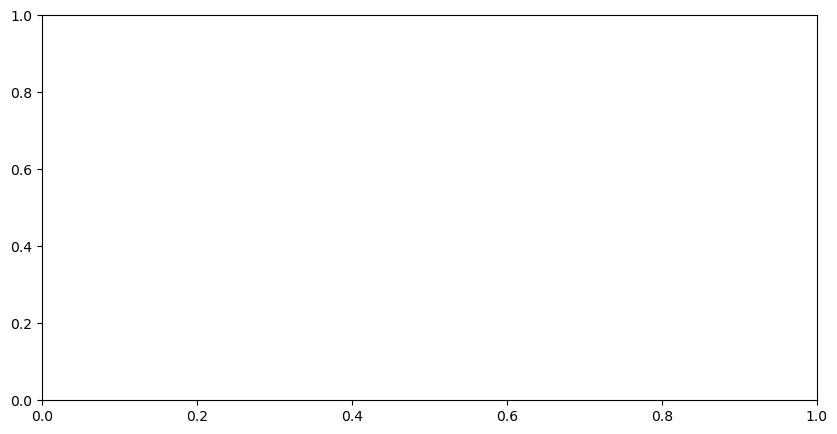

In [43]:
# 🔹 Step 7: Evaluate Performance
with torch.no_grad():
    _, decoded_source_test, _, decoded_target_test, aligned_source_test = model(X_test_torch, Y_test_torch)

mse = mean_squared_error(Y_test_torch.numpy(), aligned_source_test.numpy())
mae = mean_absolute_error(Y_test_torch.numpy(), aligned_source_test.numpy())
r2 = r2_score(Y_test_torch.numpy(), aligned_source_test.numpy())

cos_similarities = np.diag(cosine_similarity(aligned_source_test.numpy(), Y_test_torch.numpy()))

# Compute Cosine Similarity
cos_similarities = np.diag(cosine_similarity(aligned_source_test.numpy(), Y_test_torch.numpy()))

# Ensure binary labels have both 0s and 1s
threshold = np.percentile(cos_similarities, 75)  # Use median as threshold
y_true = (cos_similarities >= threshold).astype(int)  # 1 if above median, 0 otherwise


# Check if both classes exist
if len(np.unique(y_true)) < 2:
    print("⚠️ Warning: Only one class in y_true. AUC cannot be computed.")
    auc_score = None
else:
    auc_score = roc_auc_score(y_true, cos_similarities)

import numpy as np

# Check label distribution
print("Label Distribution in y_true:")
print(np.unique(y_true, return_counts=True))  # Show number of 0s and 1s


print(f"AUC Score: {auc_score if auc_score is not None else 'N/A'}")

print(f"\n🔹 Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Average Cosine Similarity: {np.mean(cos_similarities):.4f}")
print(f"AUC Score: {auc_score:.4f}")

# 🔹 Step 8: Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train & Test Loss Over Epochs")
plt.legend()
plt.show()

import matplotlib.pyplot as plt

plt.hist(cos_similarities, bins=30, edgecolor="black", alpha=0.7)
plt.xlabel("Cosine Similarity")
plt.ylabel("Number of Users")
plt.title("Cosine Similarity Distribution")
plt.show()



In [35]:
# # Delete large tensors and variables
# del mse
# del mae
# del r2
# del cos_similarities
# del y_true
# del auc_score
# del decoded_source_test
# del decoded_target_test
# del aligned_source_test

# # Clear CUDA memory if using GPU
# if torch.cuda.is_available():
#     torch.cuda.empty_cache()
#     torch.cuda.ipc_collect()

# # Force garbage collection
# import gc
# gc.collect()


13391

In [ ]:
# del ad_data
# del ecommerce_data
# del common_users
# del sampled_users
# del source_user_embeddings
# del target_user_embeddings
# del X_train_torch 
# del X_test_torch
# del Y_train_torch 
# del Y_test_torch